In [12]:
import stream_analysis as sa
import gcs 
from gcs import path_handler as ph
import os
import h5py
import pandas as pd
import numpy as np 
from scipy import optimize
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import parameterize_and_compute_impact as pci


In [13]:
# data params
GCname = "Pal5"
NP = int(1e5)
MWpotential = "pouliasis2017pii-GCNBody"
montecarlokey="monte-carlo-009"
internal_dynamics = "isotropic-plummer"

# hyper params
targetnumber        = 0
n_adjacent_points   = 5
n_stamps            = 2*n_adjacent_points+1
nDynTimes           = 2
width_factor        = 10
streampolyorder     = 2
perturberPolyOrder  = 2

dataparams  =   (GCname,NP,MWpotential,montecarlokey,internal_dynamics)
hyperparams =   (targetnumber,n_adjacent_points,nDynTimes,width_factor,streampolyorder,perturberPolyOrder)


In [3]:
fnameSnapShots,fnameSuspects,fnameHostOrbit =   pci.load_input_paths(dataparams)
suspect,targetTime,targetTau                =   pci.pick_target(fnameSuspects,targetnumber)

In [4]:
outfilename=ph.ImpactGeometry(GCname,MWpotential,montecarlokey,suspect,targetnumber)

In [5]:
time_stamps,time_indexes,coefficients_perturber,coefficients_stream,tau,galactocentric_stream,particle_filter=pci.load_and_parameterize_trajectory_and_stream(dataparams,hyperparams)

In [7]:

tauWidth    =   tau[0].max()-tau[0].min()
t_bounds    =   time_stamps[time_indexes[0]],time_stamps[time_indexes[-1]]
tau_bounds  =   [targetTau-tauWidth,targetTau+tauWidth]
# add bounds
minimization_method="L-BFGS-B"
p0      = [targetTime,targetTau]
args    = (coefficients_stream,coefficients_perturber,time_stamps[time_indexes])
bounds  = [t_bounds,tau_bounds]
results=optimize.minimize(sa.parametric_stream_fitting.objective_stream_perturber,p0,args=args,method=minimization_method,bounds=bounds)

In [8]:
impact_parameter,w_par,w_per,alpha=sa.parametric_stream_fitting.get_full_impact_geometry_from_parametrization(results.x[0],results.x[1],coefficients_stream,coefficients_perturber,time_stamps[time_indexes])
T,tau = results.x[0],results.x[1]
Mass,rh_m,_,_,_,_,_,_=gcs.extractors.MonteCarloObservables.extract_GC_observables(ph.MonteCarloObservables(suspect),montecarlokey)
Mass=Mass.value
rplum=gcs.misc.half_mass_to_plummer(rh_m.value)
profile_density=pci.extract_density_at_impact_point(GCname,MWpotential,montecarlokey,NP,internal_dynamics,T,tau)

In [9]:
geometry={"impact_parameter":impact_parameter,"w_par":w_par,"w_per":w_per,"alpha":alpha,"T":T,"tau":tau,"Mass":Mass,"rplum":rplum,"profile_density":profile_density}

In [10]:
dataparams={"GCname":GCname,"NP":NP,"MWpotential":MWpotential,"montecarlokey":montecarlokey,"internal_dynamics":internal_dynamics}
hyperparams={"targetnumber":targetnumber,"n_adjacent_points":n_adjacent_points,"nDynTimes":nDynTimes,"width_factor":width_factor,"streampolyorder":streampolyorder,"perturberPolyOrder":perturberPolyOrder}

In [11]:
myoutfile=h5py.File(outfilename,"w")

with h5py.File(outfilename,"w") as myoutfile:
    myoutfile.create_group("geometry")
    for key in geometry.keys():
        myoutfile["geometry"].create_dataset(key,data=geometry[key])

    myoutfile.create_group("dataparams")
    for key in dataparams.keys():
        myoutfile["dataparams"].create_dataset(key,data=dataparams[key])

    myoutfile.create_group("hyperparams")
    for key in hyperparams.keys():
        myoutfile["hyperparams"].create_dataset(key,data=hyperparams[key])

    myoutfile.create_dataset("time_stamps",data=time_stamps)
    myoutfile.create_dataset("time_indexes",data=time_indexes)
    myoutfile.create_dataset("coefficients_stream",data=coefficients_stream)
    myoutfile.create_dataset("coefficients_perturber",data=coefficients_perturber)
    myoutfile.create_dataset("particle_filter",data=particle_filter)

    myoutfile.create_dataset("suspect",data=suspect)
    myoutfile.close()

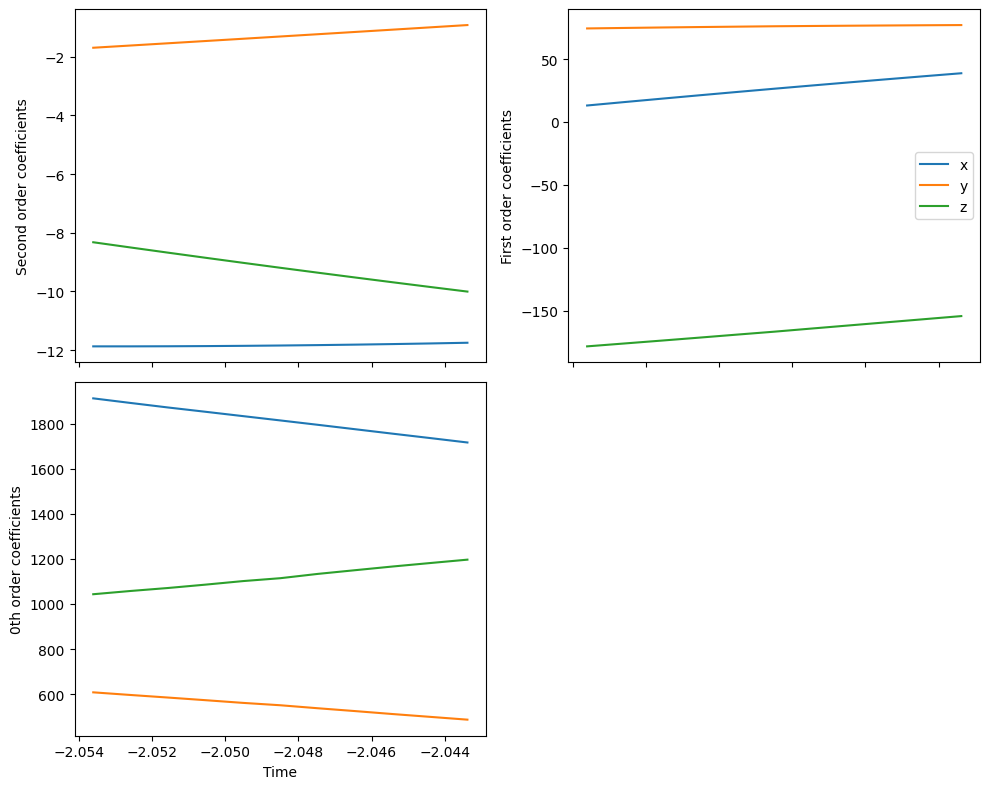

In [9]:
fig,axis=plt.subplots(2,2,figsize=(10,8),sharex=True)

coeffs=np.array(coefficients_stream)

axis[0,0].plot(time_stamps[time_indexes],coeffs[:,2])
axis[0,0].plot(time_stamps[time_indexes],coeffs[:,5])
axis[0,0].plot(time_stamps[time_indexes],coeffs[:,8])
axis[0,0].set_ylabel("Second order coefficients")

axis[0,1].plot(time_stamps[time_indexes],coeffs[:,1],label="x")
axis[0,1].plot(time_stamps[time_indexes],coeffs[:,4],label="y")
axis[0,1].plot(time_stamps[time_indexes],coeffs[:,7],label="z")
axis[0,1].set_ylabel("First order coefficients")
axis[0,1].legend()

axis[1,0].plot(time_stamps[time_indexes],coeffs[:,0])
axis[1,0].plot(time_stamps[time_indexes],coeffs[:,3])
axis[1,0].plot(time_stamps[time_indexes],coeffs[:,6])
axis[1,0].set_ylabel("0th order coefficients")
axis[1,0].set_xlabel("Time")
axis[1,1].axis('off')
fig.tight_layout()

In [125]:
# load data about impact time
rp  =   sa.parametric_stream_fitting.perturber_position(results.x[0],coefficients_perturber)
vp  =   sa.parametric_stream_fitting.perturber_velocity(results.x[0],coefficients_perturber)
# the point of impact
rsc     =   sa.parametric_stream_fitting.moving_parametric_stream(results.x[0],results.x[1],coefficients_stream,time_stamps[time_indexes])
vsc     =   sa.parametric_stream_fitting.moving_parametric_stream_velocity(results.x[0],results.x[1],coefficients_stream,time_stamps[time_indexes])

In [126]:
hostOrbit   =   gcs.extractors.GCOrbits.extract_whole_orbit(fnameHostOrbit,montecarlokey=montecarlokey)
tau_fit     =   np.linspace(tau_bounds[0],tau_bounds[1],100)

In [127]:
# params for plotting the stream
le_tau          =   results.x[1]
nDynTimes       =   2
jj              =   np.argmin(np.abs(results.x[0] - time_stamps[time_indexes]))

current_time    =   time_stamps[time_indexes[jj]]
stream_samp     =   galactocentric_stream[jj]
# get the stream fit as well as the host orbit
x_fit,y_fit,z_fit                               =   sa.parametric_stream_fitting.moving_parametric_stream(current_time,tau_fit,coefficients_stream,time_stamps[time_indexes])
tHost,xHost,yHost,zHost,vxHost,vyHost,vzHost    =   hostOrbit
tOrb,xOrb,yOrb,zOrb,vxOrb,vyOrb,vzOrb           =   sa.tailCoordinates.filter_orbit_by_dynamical_time(tHost,xHost,yHost,zHost,vxHost,vyHost,vzHost,current_time,nDynTimes=nDynTimes)

In [128]:
perturberOrbit=sa.parametric_stream_fitting.perturber_position(time_stamps[time_indexes],coefficients_perturber)

In [129]:
# prepare the plot 
width = 0.5
xlims,ylims,zlims = [rsc[0]-width,rsc[0]+width],[rsc[1]-width,rsc[1]+width],[rsc[2]-width,rsc[2]+width]

In [130]:
# Create traces
stream_trace = go.Scatter3d(
    x=stream_samp[0],
    y=stream_samp[1],
    z=stream_samp[2],
    mode='markers',
    name='stream',
    marker=dict(color='blue', size=1,opacity=0.5)
)

stream_fit_trace = go.Scatter3d(
    x=x_fit,
    y=y_fit,
    z=z_fit,
    mode='lines',
    name='stream fit',
    line=dict(color='blue')
)

host_trace_orbit = go.Scatter3d(
    x=xOrb,
    y=yOrb,
    z=zOrb,
    mode='lines',
    name='host orbit',
    line=dict(color='black')
)

perturber_trace_orbit = go.Scatter3d(
    x=perturberOrbit[0],
    y=perturberOrbit[1],
    z=perturberOrbit[2],
    mode='lines',
    name='perturber orbit',
    line=dict(color='red')
)

perturber_trace_scatter = go.Scatter3d(
    x=[rp[0]],
    y=[rp[1]],
    z=[rp[2]],
    mode='markers',
    name='perturber',
    marker=dict(color='red', size=5)
)

# Create layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(range=xlims),
        yaxis=dict(range=ylims),
        zaxis=dict(range=zlims),
    ),
    width=1000,
    height=500
)


In [131]:
# Create figure
fig = go.Figure(data=[stream_trace, stream_fit_trace,perturber_trace_orbit,host_trace_orbit, perturber_trace_scatter], layout=layout)

# Show plot
pio.show(fig)
pio.write_html(fig, file='{:s}-{:s}.html'.format(montecarlokey,suspect), auto_open=True)

Loading "original-fs" failed
Error: Cannot find module 'original-fs'
Require stack:
- /home/sferrone/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/out/server-cli.js
    at Module._resolveFilename (node:internal/modules/cjs/loader:1145:15)
    at Module._load (node:internal/modules/cjs/loader:986:27)
    at Module.require (node:internal/modules/cjs/loader:1233:19)
    at require (node:internal/modules/helpers:179:18)
    at i (/home/sferrone/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/out/server-cli.js:3:98)
    at r.load (/home/sferrone/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/out/server-cli.js:2:1637)
    at h.load (/home/sferrone/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/out/server-cli.js:1:13958)
    at u (/home/sferrone/.vscode-server/cli/servers/Stable-b1c0a14de1414fcdaa400695b4db1c0799bc3124/server/out/server-cli.js:3:9338)
   